# Translation Efficiency Prediction with OmniGenBench

This notebook demonstrates how to fine-tune a Genomic Foundation Model (GFM) to predict Rice translation efficiency (TE) from mRNA sequences using OmniGenBench. The example focusing on plant RNA translation efficiency.

**Background (PlantRNA-FM):**
PlantRNA-FM ("An interpretable RNA foundation model for exploring functional RNA motifs in plants") introduces an RNA foundation model tailored to plant genomics, highlighting interpretability and motif discovery capabilities. TE prediction is a representative downstream task where models learn sequence determinants associated with efficient translation. In this demo, we use a small rice 5'UTR/mRNA TE dataset to illustrate fine-tuning and evaluation within OmniGenBench.

- **Task type**: Binary sequence classification (High-TE vs Low-TE)
- **Input**: RNA sequences (string), up to a configurable `max_length`
- **Label space**: {0: Low-TE, 1: High-TE}

**Estimated runtime:** On a single NVIDIA RTX 4090, a short training run on this toy dataset typically takes ~10–30 minutes depending on epochs/model size.

##  Notebook Structure
 **Setup & Installation**: Install optional dependencies.
2. **Import Libraries**: Load Python packages and local utilities.
3. **Configuration & Data**: Choose a model, set hyperparameters, and point to dataset files.
4. **Main Analysis Pipeline**: Run training/evaluation with `utils.run_training`.
5. **Results Overview**: Summarize validation/test metrics.
6. **Visualization**: Plot validation metrics across epochs.
7. **References**: Link to PlantRNA-FM.

## 1. Setup & Installation

This section handles the initial setup, including installing necessary packages. If dependencies are already available, you can skip the installation cell.

### Install Dependencies
Uncomment and run the following cell to install the required packages.

In [1]:
# Optional: install dependencies if not available
# !pip install torch transformers pandas autocuda multimolecule biopython scipy scikit-learn tqdm dill findfile requests omnigenbench


## 2. Import Libraries
Import all necessary libraries for data processing, model training, and analysis.

In [2]:
import warnings
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from autocuda import auto_cuda

# Import utilities from the local utils.py file
utils_spec = importlib.util.spec_from_file_location("utils", "utils.py")
utils = importlib.util.module_from_spec(utils_spec)
utils_spec.loader.exec_module(utils)

warnings.filterwarnings('ignore')
print("Libraries imported successfully!")


C:\Users\hengu\miniconda3\envs\py312\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(



    **@@ #========= @@**            ___                     _
      **@@ +----- @@**             / _ \  _ __ ___   _ __  (_)
        **@@ = @@**               | | | || '_ ` _ \ | '_ \ | |
           **@@                   | |_| || | | | | || | | || |
        @@** = **@@                \___/ |_| |_| |_||_| |_||_|
     @@** ------+ **@@
   @@** =========# **@@            ____
  @@ ---------------+ @@          / ___|  ___  _ __
 @@ ================== @@        | |  _  / _ \| '_ \
  @@ +--------------- @@         | |_| ||  __/| | | |
   @@** #========= **@@           \____| \___||_| |_|
    @@** +------ **@@
       @@** = **@@
          @@**                    ____                      _
       **@@ = @@**               | __ )   ___  _ __    ___ | |__
    **@@ -----+  @@**            |  _ \  / _ \| '_ \  / __|| '_ \
  **@@ ==========# @@**          | |_) ||  __/| | | || (__ | | | |
  @@ --------------+ @@**        |____/  \___||_| |_| \___||_| |_|

Libraries imported successfully!


## 3. Configuration & Data

Set up the analysis parameters, file paths, and model selection here. You can easily change the `MODEL_NAME` to test different GFMs.

### Model Selection
Choose the Genomic Foundation Model to fine-tune.

In [3]:
# Using utils for reusable logic
from utils import run_finetuning
print("Core classes and functions imported from utils.")

# --- Available Models for Testing ---
AVAILABLE_MODELS = [
    # 'yangheng/OmniGenome-52M',
    # 'yangheng/OmniGenome-186M',
    'yangheng/OmniGenome-v1.5',
]
MODEL_NAME = AVAILABLE_MODELS[0]  # Model to use for predictions
print(f"Selected model: {MODEL_NAME}")


Core classes and functions imported from utils.
Selected model: yangheng/OmniGenome-v1.5


### Hyperparameter and Dataset Configuration
Define the training hyperparameters and paths to the dataset files.

In [4]:
import findfile

# --- Training Hyperparameters ---
EPOCHS = 10
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 4
MAX_LENGTH = 1024
SEED = 42

# --- Dataset Configuration ---
LOCAL_PATH = "te_rice_dataset"  # Local directory for the dataset
from utils import download_te_dataset
download_te_dataset(LOCAL_PATH)  # Download the VEP dataset if not already available

# --- Dataset Configuration ---
TRAIN_FILE = findfile.find_cwd_file("train.json")  # training split
VALID_FILE = findfile.find_cwd_file("valid.json")  # validation split (optional)
TEST_FILE = findfile.find_cwd_file("test.json")  # test split
# --- Label Mapping ---
# The task is binary classification: 1 for TE, 0 for non-TE.
LABEL2ID = {"0": 0, "1": 1}

print(f"Selected model: {MODEL_NAME}")


Downloaded te_rice_dataset\te_rice_dataset.zip
Extracted te_rice_dataset.zip into te_rice_dataset
Selected model: yangheng/OmniGenome-v1.5


## 4. Main Analysis Pipeline

This section executes the training/evaluation pipeline using the configuration defined above. The `run_training` function from `examples/translation_efficiency_prediction/utils.py` orchestrates tokenization, dataset creation, training, and evaluation.

In [5]:
# Import main pipeline from utils for a concise demo
from utils import run_finetuning

print("Main analysis pipeline imported from utils.")

print("=" * 50)

# Run the analysis
metrics = run_finetuning(
	model_name=MODEL_NAME,
	train_file=TRAIN_FILE,
	valid_file=VALID_FILE,
	test_file=TEST_FILE,
	label2id=LABEL2ID,
	epochs=EPOCHS,
	learning_rate=LEARNING_RATE,
	weight_decay=WEIGHT_DECAY,
	batch_size=BATCH_SIZE,
	max_length=MAX_LENGTH,
	seed=SEED,
)

print("=" * 50)
print("Analysis completed!")

# Print final validation and test metrics (if available)
if metrics.get('valid'):
	print("\nValidation Set Performance (last epoch):")
	for key, value in metrics['valid'][-1].items():
		print(f"{key}: {value:.4f}")

if metrics.get('test'):
	print("\nTest Set Performance (best checkpoint):")
	for key, value in metrics['test'][-1].items():
		print(f"{key}: {value:.4f}")


Main analysis pipeline imported from utils.


Some weights of OmniGenomeModel were not initialized from the model checkpoint at yangheng/OmniGenome-v1.5 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[2025-08-16 15:20:56] [omnigenome 0.3.8alpha]  Model Name: OmniModelForSequenceClassification
Model Metadata: {'library_name': 'omnigenbench', 'omnigenbench_version': '0.3.8alpha', 'torch_version': '2.7.0+cu128+cu12.8+git134179474539648ba7dee1317959529fbd0e7f89', 'transformers_version': '4.55.0', 'model_cls': 'OmniModelForSequenceClassification', 'tokenizer_cls': 'EsmTokenizer', 'model_name': 'OmniModelForSequenceClassification'}
Base Model Name: yangheng/OmniGenome-v1.5
Model Type: omnigenome
Model Architecture: ['OmniGenomeForMaskedLM']
Model Parameters: 185.886801 M
Model Config: OmniGenomeConfig {
  "OmniGenomefold_config": null,
  "architectures": [
    "OmniGenomeForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "auto_map": {
    "AutoConfig": "configuration_omnigenome.OmniGenomeConfig",
    "AutoModel": "modeling_omnigenome.OmniGenomeModel",
    "AutoModelForMaskedLM": "modeling_omnigenome.OmniGenomeForMaskedLM",
    "AutoModelForSeq2SeqLM": "modeling_omnigenome.OmniGen

100%|██████████| 4697/4697 [00:09<00:00, 513.13it/s]


[2025-08-16 15:21:06] [omnigenome 0.3.8alpha]  
Label Distribution:
[2025-08-16 15:21:06] [omnigenome 0.3.8alpha]  ----------------------------------------
[2025-08-16 15:21:06] [omnigenome 0.3.8alpha]  Label     		Count     		Percentage
[2025-08-16 15:21:06] [omnigenome 0.3.8alpha]  ----------------------------------------
[2025-08-16 15:21:06] [omnigenome 0.3.8alpha]  0         		2195      		46.73%
[2025-08-16 15:21:06] [omnigenome 0.3.8alpha]  1         		2502      		53.27%
[2025-08-16 15:21:06] [omnigenome 0.3.8alpha]  ----------------------------------------
[2025-08-16 15:21:06] [omnigenome 0.3.8alpha]  Total samples: 4697
[2025-08-16 15:21:06] [omnigenome 0.3.8alpha]  Max sequence length updated -> Reset max_length=504, label_padding_length=0
[2025-08-16 15:21:06] [omnigenome 0.3.8alpha]  Detected max_length=1024 in the dataset, using it as the max_length.
[2025-08-16 15:21:06] [omnigenome 0.3.8alpha]  Loading data from te_rice_dataset\valid.json...
[2025-08-16 15:21:06] [omnige

100%|██████████| 587/587 [00:01<00:00, 513.42it/s]


[2025-08-16 15:21:07] [omnigenome 0.3.8alpha]  
Label Distribution:
[2025-08-16 15:21:07] [omnigenome 0.3.8alpha]  ----------------------------------------
[2025-08-16 15:21:07] [omnigenome 0.3.8alpha]  Label     		Count     		Percentage
[2025-08-16 15:21:07] [omnigenome 0.3.8alpha]  ----------------------------------------
[2025-08-16 15:21:07] [omnigenome 0.3.8alpha]  0         		259       		44.12%
[2025-08-16 15:21:07] [omnigenome 0.3.8alpha]  1         		328       		55.88%
[2025-08-16 15:21:07] [omnigenome 0.3.8alpha]  ----------------------------------------
[2025-08-16 15:21:07] [omnigenome 0.3.8alpha]  Total samples: 587
[2025-08-16 15:21:07] [omnigenome 0.3.8alpha]  Max sequence length updated -> Reset max_length=504, label_padding_length=0
[2025-08-16 15:21:07] [omnigenome 0.3.8alpha]  Detected max_length=1024 in the dataset, using it as the max_length.
[2025-08-16 15:21:07] [omnigenome 0.3.8alpha]  Loading data from te_rice_dataset\test.json...
[2025-08-16 15:21:07] [omnigeno

100%|██████████| 588/588 [00:01<00:00, 513.69it/s]


[2025-08-16 15:21:08] [omnigenome 0.3.8alpha]  
Label Distribution:
[2025-08-16 15:21:08] [omnigenome 0.3.8alpha]  ----------------------------------------
[2025-08-16 15:21:08] [omnigenome 0.3.8alpha]  Label     		Count     		Percentage
[2025-08-16 15:21:08] [omnigenome 0.3.8alpha]  ----------------------------------------
[2025-08-16 15:21:08] [omnigenome 0.3.8alpha]  0         		258       		43.88%
[2025-08-16 15:21:08] [omnigenome 0.3.8alpha]  1         		330       		56.12%
[2025-08-16 15:21:08] [omnigenome 0.3.8alpha]  ----------------------------------------
[2025-08-16 15:21:08] [omnigenome 0.3.8alpha]  Total samples: 588
[2025-08-16 15:21:08] [omnigenome 0.3.8alpha]  Max sequence length updated -> Reset max_length=504, label_padding_length=0
Datasets and DataLoaders created.


Evaluating: 100%|██████████| 147/147 [00:09<00:00, 15.66it/s]


[2025-08-16 15:21:18] [omnigenome 0.3.8alpha]  {'f1_score': 0.45696243262810715}


Evaluating: 100%|██████████| 147/147 [00:08<00:00, 16.89it/s]


[2025-08-16 15:24:58] [omnigenome 0.3.8alpha]  {'f1_score': 0.7333977002367138}


Evaluating: 100%|██████████| 147/147 [00:08<00:00, 16.37it/s]


[2025-08-16 15:28:33] [omnigenome 0.3.8alpha]  {'f1_score': 0.7335916771400642}


Evaluating: 100%|██████████| 147/147 [00:08<00:00, 16.67it/s]


[2025-08-16 15:32:13] [omnigenome 0.3.8alpha]  {'f1_score': 0.745410353811}


Evaluating: 100%|██████████| 147/147 [00:08<00:00, 16.71it/s]


[2025-08-16 15:35:56] [omnigenome 0.3.8alpha]  {'f1_score': 0.7481900665209318}


Evaluating: 100%|██████████| 147/147 [00:08<00:00, 16.63it/s]


[2025-08-16 15:39:33] [omnigenome 0.3.8alpha]  {'f1_score': 0.7499358076563959}


Evaluating: 100%|██████████| 147/147 [00:09<00:00, 15.76it/s]


[2025-08-16 15:43:19] [omnigenome 0.3.8alpha]  {'f1_score': 0.744159244146081}


Evaluating: 100%|██████████| 147/147 [00:09<00:00, 15.27it/s]


[2025-08-16 15:47:06] [omnigenome 0.3.8alpha]  {'f1_score': 0.7422001264844353}


Evaluating: 100%|██████████| 147/147 [00:09<00:00, 16.03it/s]


[2025-08-16 15:50:56] [omnigenome 0.3.8alpha]  {'f1_score': 0.7403320062396685}


Evaluating: 100%|██████████| 147/147 [00:09<00:00, 15.79it/s]


[2025-08-16 15:54:42] [omnigenome 0.3.8alpha]  {'f1_score': 0.7580744404198012}


Evaluating: 100%|██████████| 147/147 [00:09<00:00, 15.86it/s]


[2025-08-16 15:58:34] [omnigenome 0.3.8alpha]  {'f1_score': 0.699219750786072}


Testing: 100%|██████████| 147/147 [00:09<00:00, 16.03it/s]


[2025-08-16 15:58:44] [omnigenome 0.3.8alpha]  {'f1_score': 0.7431965361554681}
[2025-08-16 15:58:45] [omnigenome 0.3.8alpha]  The model is saved to finetuned_te_model.
Training completed!
Analysis completed!

Validation Set Performance (last epoch):
f1_score: 0.6992

Test Set Performance (best checkpoint):
f1_score: 0.7432


## 5. Inference  Example
This section demonstrates how to run inference on a single sequence using the fine-tuned model. The `encode_tokens` function ensures the same preprocessing as during training.

In [6]:
from omnigenbench import ModelHub

model = ModelHub.load("finetuned_te_model").to(auto_cuda()).to(torch.float16)

# Example sequence for inference
sample_sequence1 = "AAACCAACAAAATGCAGTAGAAGTACTCTCGAGCTATAGTCGCGACGTGCTGCCCCGCAGGAGTACAGTAGTAGTACAACGTAAGCGGGAGCAACAGACTCCCCCCCTGCAACCCACTGTGCCTGTGCCCTCGACGCGTCTCCGTCGCTTTGGCAAATGTCACGTACATATTACCGTCTCAGGCTCTCAGCCATGCTCCCTACCACCCCTGCAGCGAAGCAAAAGCCACGCACGCGGCGCCTGACATGTAACAGGACTAGACCATCTTGTTCATTTCCCGCACCCCCTCCTCTCCTCTTCCTCCATCTGCCTCTTTAAAACAGTAAAAATAACCGTGCATCCCCTGGGCAAAATCTCTCCCATACATACACTACAGCGGCGAACCTTTCCTTATTCTCGCAACGCCTCGGTAACGGGCAGCGCCTGCTCCGCGCCGCGGTTGCGAGTTCGGGAAGGCGGCCGGAGTCGCGGGGAGGAGAGGGAGGATTCGATCGGCCAGA"  # High-TE sequence

sample_sequence2 = "TGGAGATGGGCAGATGGCACACAAAACATGAATAGAAAACCCAAAAGGAAGGATGAAAAAAACACACACACACACACACACAAAACACAGAGAGAGAGAGAGAGAGAGAGCGAGAAAAGAAAAGAAAAAACCAATTCTTTTGGTCTCTTCCCTCTCCGTTTGTCGTGTCGAAGCCTTTGCCCCCACCACCTCCTCCTCTCCTCTCCCTTCCTCCCCTCCTCCCCATCTCGCTCTCCTCCCTCCTCTCTCCTCTCCTCGTCTCCTCTTCCTCTCCATTCCATTGGCCATTCCATTCCATTCCACCCCCCATGAAACCCCAAACCCTCGTCGGCCTCGCCGCGCTCGCGTAGCGCACCCGCCCTTCTCCTCTCGCCGGTGGTCCGCCGCCAGCCTCCCCCCACCCGATCCCGCCGCCCCCCCCGCCTTCACCCCGCCCACGCGGACGCATCCGATCCCGCCGCATCGCCGCGCGGGGGGGGGGGGGGGGGGGGGAGGGCACG "  # Low-TE sequence

# Run inference on the sample sequences
outputs = model.inference(sample_sequence1)
print(f"Sample sequence 1 prediction: {outputs}")
outputs = model.inference(sample_sequence2)
print(f"Sample sequence 2 prediction: {outputs}")



The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'EsmTokenizer'. 
The class this function is called from is 'RnaTokenizer'.


[2025-08-16 15:58:57] [omnigenome 0.3.8alpha]  Model Name: OmniModelForSequenceClassification
Model Metadata: {'library_name': 'omnigenbench', 'omnigenbench_version': '0.3.8alpha', 'torch_version': '2.7.0+cu128+cu12.8+git134179474539648ba7dee1317959529fbd0e7f89', 'transformers_version': '4.55.0', 'model_cls': 'OmniModelForSequenceClassification', 'tokenizer_cls': 'RnaTokenizer', 'model_name': 'OmniModelForSequenceClassification'}
Base Model Name: finetuned_te_model
Model Type: omnigenome
Model Architecture: ['OmniGenomeModel']
Model Parameters: 185.886801 M
Model Config: OmniGenomeConfig {
  "OmniGenomefold_config": null,
  "architectures": [
    "OmniGenomeModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "auto_map": {
    "AutoConfig": "configuration_omnigenome.OmniGenomeConfig",
    "AutoModel": "modeling_omnigenome.OmniGenomeModel",
    "AutoModelForMaskedLM": "modeling_omnigenome.OmniGenomeForMaskedLM",
    "AutoModelForSeq2SeqLM": "modeling_omnigenome.OmniGenomeForSeq2SeqLM",


## 6. Visualization

In this section, we visualize validation metrics across epochs to assess learning dynamics.

### Plot Validation Curves
We plot macro F1 across epochs. Additional metrics (e.g., MCC) can be added if enabled in `utils.py` or dataset config.


In [7]:
# Results Overview — Quick summary of metrics
if metrics.get('valid'):
	print('Validation (last epoch):')
	for k, v in metrics['valid'][-1].items():
		print(f"{k}: {v:.4f}")

if metrics.get('test'):
	print('\nTest (best checkpoint):')
	for k, v in metrics['test'][-1].items():
		print(f"{k}: {v:.4f}")


Validation (last epoch):
f1_score: 0.6992

Test (best checkpoint):
f1_score: 0.7432


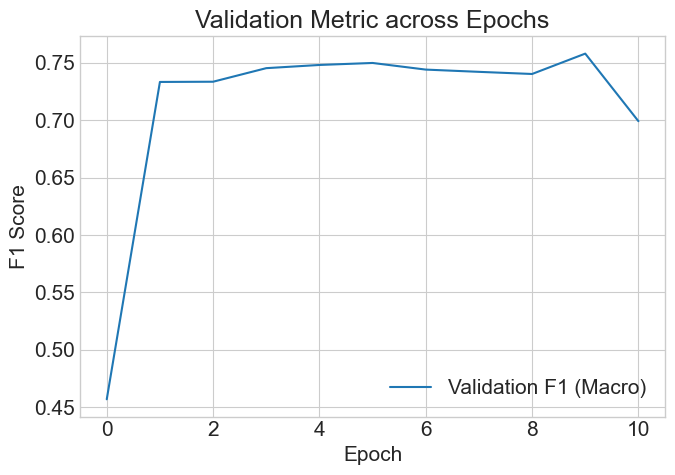

In [8]:
# Visualization — Plot validation curve
valid_key = 'valid' if 'valid' in metrics else ('eval' if 'eval' in metrics else None)
if valid_key is None:
	print("No validation metrics found for plotting.")
else:
	valid_df = pd.DataFrame(metrics[valid_key])
	plt.style.use('seaborn-v0_8-whitegrid')
	fig, ax = plt.subplots(1, 1, figsize=(7, 5))
	if 'f1_score' in valid_df.columns:
		sns.lineplot(data=valid_df, x=valid_df.index, y='f1_score', ax=ax, label='Validation F1 (Macro)')
		ax.set_ylabel('F1 Score')
	elif 'matthews_corrcoef' in valid_df.columns:
		sns.lineplot(data=valid_df, x=valid_df.index, y='matthews_corrcoef', ax=ax, label='Validation MCC')
		ax.set_ylabel('MCC')
	else:
		first_col = [c for c in valid_df.columns if isinstance(valid_df[c].iloc[-1], (int, float))]
		if first_col:
			sns.lineplot(data=valid_df, x=valid_df.index, y=first_col[0], ax=ax, label=first_col[0])
			ax.set_ylabel(first_col[0])
		else:
			print("Validation metrics exist but no numeric columns to plot.")
	ax.set_title('Validation Metric across Epochs')
	ax.set_xlabel('Epoch')
	ax.legend()
	plt.tight_layout()
	plt.show()

## References

- PlantRNA-FM: "An interpretable RNA foundation model for exploring functional RNA motifs in plants" (Nature Machine Intelligence, 2024).
